In [1]:
# Module Import
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
# 딥러닝 모델을 설계할 때 사용하는 장비 확인
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device("cpu")

print("Using PyTorch version:", torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.7.0  Device: cuda


In [4]:
BATCH_SIZE = 32
EPOCHS = 30

In [5]:
# MNIST 데이터 다운로드
train_dataset = datasets.MNIST(root = "../data/MNIST",
                              train = True,
                              download = True,
                              transform = transforms.ToTensor())
test_dataset = datasets.MNIST(root = "../data/MNIST",
                             train = False,
                             transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                         batch_size = BATCH_SIZE,
                                         shuffle = False)

In [6]:
# 데이터 확인
for(x_train, y_train) in train_loader:
    print("X_train:", x_train.size(), 'type:', x_train.type())
    print("y_train", y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train torch.Size([32]) type: torch.LongTensor


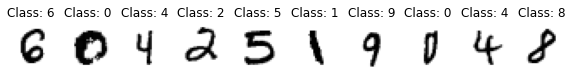

In [7]:
# 데이터 시각화
pltsize = 1
plt.figure(figsize = (10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(x_train[i, :, :, :].numpy().reshape(28, 28), cmap = 'gray_r')
    plt.title('Class: ' + str(y_train[i].item()))

In [13]:
# MLP(Multi Layer Perceptron) 모델 설계
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout_prob = 0.5
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc3(x)
        x = F.sigmoid(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [14]:
# Optimizer, Objective Function
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [18]:
# MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수
def train(model, train_loader, optimizer, log_interval):
    model.train()
    model.training = True
    
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(Epoch, batch_idx * len(image),
                                                                               len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                                                                               loss.item()))

In [19]:
# 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, test_loader):
    model.eval()
    model.training=False
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [20]:
# MLP 학습시키며 Train, Test set의 Loss 및 Test set Accuracy를 확인
for Epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".format(Epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000(0%)]	Train Loss: 2.283702
Train Epoch: 1 [6400/60000(11%)]	Train Loss: 2.299196
Train Epoch: 1 [12800/60000(21%)]	Train Loss: 2.305451
Train Epoch: 1 [19200/60000(32%)]	Train Loss: 2.294787
Train Epoch: 1 [25600/60000(43%)]	Train Loss: 2.314350
Train Epoch: 1 [32000/60000(53%)]	Train Loss: 2.295473
Train Epoch: 1 [38400/60000(64%)]	Train Loss: 2.305004
Train Epoch: 1 [44800/60000(75%)]	Train Loss: 2.290615
Train Epoch: 1 [51200/60000(85%)]	Train Loss: 2.298548
Train Epoch: 1 [57600/60000(96%)]	Train Loss: 2.272201

[EPOCH: 1], 	Test Loss: 0.0712, 	Test Accuracy: 36.55 %

Train Epoch: 2 [0/60000(0%)]	Train Loss: 2.301048
Train Epoch: 2 [6400/60000(11%)]	Train Loss: 2.288892
Train Epoch: 2 [12800/60000(21%)]	Train Loss: 2.279295
Train Epoch: 2 [19200/60000(32%)]	Train Loss: 2.271452
Train Epoch: 2 [25600/60000(43%)]	Train Loss: 2.278900
Train Epoch: 2 [32000/60000(53%)]	Train Loss: 2.243847
Train Epoch: 2 [38400/60000(64%)]	Train Loss: 2.296336
Train Epoch: 2 [448

Train Epoch: 14 [38400/60000(64%)]	Train Loss: 1.818341
Train Epoch: 14 [44800/60000(75%)]	Train Loss: 1.770335
Train Epoch: 14 [51200/60000(85%)]	Train Loss: 1.769101
Train Epoch: 14 [57600/60000(96%)]	Train Loss: 1.729534

[EPOCH: 14], 	Test Loss: 0.0550, 	Test Accuracy: 62.56 %

Train Epoch: 15 [0/60000(0%)]	Train Loss: 1.807569
Train Epoch: 15 [6400/60000(11%)]	Train Loss: 1.836169
Train Epoch: 15 [12800/60000(21%)]	Train Loss: 1.782104
Train Epoch: 15 [19200/60000(32%)]	Train Loss: 1.802412
Train Epoch: 15 [25600/60000(43%)]	Train Loss: 1.924171
Train Epoch: 15 [32000/60000(53%)]	Train Loss: 1.784240
Train Epoch: 15 [38400/60000(64%)]	Train Loss: 1.742103
Train Epoch: 15 [44800/60000(75%)]	Train Loss: 1.825655
Train Epoch: 15 [51200/60000(85%)]	Train Loss: 1.779862
Train Epoch: 15 [57600/60000(96%)]	Train Loss: 1.732509

[EPOCH: 15], 	Test Loss: 0.0548, 	Test Accuracy: 61.64 %

Train Epoch: 16 [0/60000(0%)]	Train Loss: 1.819848
Train Epoch: 16 [6400/60000(11%)]	Train Loss: 1.73178


[EPOCH: 27], 	Test Loss: 0.0536, 	Test Accuracy: 58.54 %

Train Epoch: 28 [0/60000(0%)]	Train Loss: 1.705284
Train Epoch: 28 [6400/60000(11%)]	Train Loss: 1.695643
Train Epoch: 28 [12800/60000(21%)]	Train Loss: 1.730115
Train Epoch: 28 [19200/60000(32%)]	Train Loss: 1.831147
Train Epoch: 28 [25600/60000(43%)]	Train Loss: 1.697977
Train Epoch: 28 [32000/60000(53%)]	Train Loss: 1.724148
Train Epoch: 28 [38400/60000(64%)]	Train Loss: 1.676481
Train Epoch: 28 [44800/60000(75%)]	Train Loss: 1.694937
Train Epoch: 28 [51200/60000(85%)]	Train Loss: 1.718991
Train Epoch: 28 [57600/60000(96%)]	Train Loss: 1.685880

[EPOCH: 28], 	Test Loss: 0.0536, 	Test Accuracy: 56.67 %

Train Epoch: 29 [0/60000(0%)]	Train Loss: 1.733369
Train Epoch: 29 [6400/60000(11%)]	Train Loss: 1.696751
Train Epoch: 29 [12800/60000(21%)]	Train Loss: 1.799235
Train Epoch: 29 [19200/60000(32%)]	Train Loss: 1.733144
Train Epoch: 29 [25600/60000(43%)]	Train Loss: 1.697622
Train Epoch: 29 [32000/60000(53%)]	Train Loss: 1.72807